In [18]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pdb

from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
#Same Random data at the gpflow example, but its in pytorch tensors.
freq = 10

#This is just for plotting
Xexact = torch.linspace(0,2,100)
Yexact = torch.sin(Xexact*freq)
dYdXexact = freq*torch.cos(Xexact*freq)

#This is what will go into the GP fit
Ndata = 1000
sigma = 0.1
Xdata = 2*torch.rand(Ndata)
Ydata = torch.sin(Xdata * freq) + sigma * torch.randn(Ndata)
sigdata = 0.1*torch.ones(Ndata) + torch.abs(sigma * torch.randn(Ndata))

In [229]:
sigdata**2

tensor([0.0239, 0.0120, 0.0126, 0.0218, 0.0132, 0.0480, 0.0142, 0.0362, 0.0192,
        0.1413, 0.0151, 0.0357, 0.0622, 0.0173, 0.0254, 0.0617, 0.0276, 0.0718,
        0.0268, 0.0308, 0.0750, 0.0123, 0.0244, 0.0306, 0.0327, 0.0402, 0.0274,
        0.0476, 0.0277, 0.0152, 0.0112, 0.0642, 0.0770, 0.0108, 0.0109, 0.0265,
        0.0274, 0.0127, 0.0272, 0.0100, 0.0373, 0.0518, 0.0116, 0.0128, 0.0128,
        0.0121, 0.0261, 0.0732, 0.0135, 0.1418, 0.0212, 0.1179, 0.1139, 0.0239,
        0.0128, 0.0111, 0.0235, 0.0161, 0.0255, 0.0451, 0.0784, 0.0537, 0.0477,
        0.0526, 0.0511, 0.0495, 0.0213, 0.0455, 0.0159, 0.0289, 0.0359, 0.0831,
        0.0119, 0.0324, 0.0127, 0.0121, 0.0375, 0.0267, 0.0885, 0.0526, 0.0521,
        0.0231, 0.0380, 0.0341, 0.0458, 0.0306, 0.0120, 0.0207, 0.0166, 0.0156,
        0.0373, 0.0199, 0.0167, 0.0247, 0.0627, 0.0700, 0.0152, 0.0572, 0.0272,
        0.0399, 0.1098, 0.0664, 0.0904, 0.0868, 0.0177, 0.0154, 0.0364, 0.0107,
        0.0329, 0.0465, 0.0570, 0.0492, 

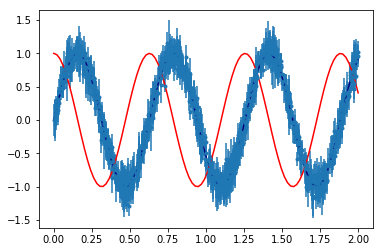

In [158]:
plt.errorbar(Xdata.numpy(), Ydata.numpy(), yerr=sigdata.numpy(),fmt='.')
plt.plot(Xexact.numpy(),Yexact.numpy(),color='navy')
plt.plot(Xexact.numpy(),dYdXexact.numpy()/10,color='red')

### Build the Model

In [191]:
%reload_ext autoreload
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=2.5))#
        #self.covar_module = MaternKernel(nu=2.5)#
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
                noise=sigdata**2, learn_additional_noise=False)
model = ExactGPModel(Xdata, Ydata, likelihood)

### Train the Model

In [192]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': model.parameters()},  # Includes GaussianLikelihood parameters
            ], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xdata)
    # Calc loss and backprop gradients
    loss = -mll(output, Ydata)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item()
#         ))
    optimizer.step()

### Derivative of Matern 5/2 Kernel

In [193]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

FixedNoiseGaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): FixedGaussianNoise()
)

In [194]:
model

ExactGPModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [226]:
#N data points
#M test points
#D dimensions 

#Extract data X values
model.train_inputs[0].shape #X input data values, NxD
model.train_targets.shape # Y data values, N

torch.Size([1000])

In [230]:
#Extract sigmas 
model.likelihood.noise_covar.noise.shape  # variances

torch.Size([1000])

In [198]:
#Extract kernel variances
model.covar_module.outputscale #I think this is it

tensor(1.4285, grad_fn=<SoftplusBackward>)

In [249]:
#Extract KXX
KXXinv = model.covar_module.base_kernel(Xdata.reshape(-1,1),Xdata.reshape(-1,1))\
        .add_diag(model.likelihood.noise_covar.noise).evaluate().inverse()

In [264]:
#Calculate alpha
alpha = torch.matmul(KXXinv, model.train_targets)

In [265]:
alpha.shape

torch.Size([1000])

In [269]:
Xtest1 = torch.Tensor([1.5])
Xtest1

tensor([1.5000])

In [270]:
kxX = model.covar_module.base_kernel(Xtest1.reshape(-1,1),Xdata.reshape(-1,1))

In [295]:
kxX.evaluate().shape[1]

1000

In [ ]:
#Extract lengthscales
model.covar_module.base_kernel.lengthscale #Dx1 or 1xD

In [302]:
fstar_test, D1,D2 = dfdx_calc_Matern52(model, Xtest)

> <ipython-input-301-e6aacacda4fd>(7)dfdx_calc_Matern52()
-> KXXinv = model.covar_module.base_kernel(model.train_inputs[0].reshape(-1,1),
(Pdb) c
> <ipython-input-301-e6aacacda4fd>(72)dfdx_calc_Matern52()
-> mean_dfdx_list = 0
(Pdb) c


In [301]:
def dfdx_calc_Matern52(model, Xstar_list):
    
    # M test points
    # N data points
    # D dimensions
    pdb.set_trace()
    KXXinv = model.covar_module.base_kernel(model.train_inputs[0].reshape(-1,1),
                                            model.train_inputs[0].reshape(-1,1))\
                .add_diag(model.likelihood.noise_covar.noise).evaluate().inverse() #NxN
     
    alpha = torch.matmul(KXXinv, model.train_targets).reshape(-1,1) #Nx1
    
    kxX_list = torch.stack([model.covar_module.base_kernel(Xstarii.reshape(-1,1),
                    model.train_inputs[0].reshape(-1,1)).evaluate()\
                    for Xstarii in Xstar_list]) #MxDxN
    
    fstar_list = torch.stack([torch.matmul(kxX_list[ii],alpha) for ii in range(kxX_list.shape[0])])
        
    pdb.set_trace()
    
    
    
#     like_variances = mod.likelihood.read_values()['GPR/likelihood/variance']
#     KXX = mod.kern.K(mod.X.value, mod.X.value,).eval() + np.diag(like_variances.reshape(-1)) #N x N
#     if np.linalg.det(KXX)==0.0:
#         print("WARNING: KXX (close to) singular.")

#     KXXinv = np.linalg.inv(KXX) #N x N
#     Lcho_KXX = np.linalg.cholesky(KXX)
#     Lcho_inv_KXX = np.linalg.inv(Lcho_KXX)
#     KXXinv_cho = np.matmul(Lcho_inv_KXX.T, Lcho_inv_KXX)
#     KXXinv = KXXinv_cho

#     alpha = np.dot(KXXinv, mod.Y.value) #N x 1

#     # Extract lengthscales
#     lengthscales = np.array([mod.read_trainables()[key] for key in list(mod.read_trainables().keys())\
#                     if 'lengthscales' in key]).reshape(-1)
#     InvLambda = np.diag(1/(lengthscales**2)) #DxD
#     #InvLambda = np.diag(1/(lengthscales)) #DxD

#     # Extract Kernel Variances
#     kernel_variances = np.diag(np.array([mod.read_trainables()[key] \
#                                          for key in list(mod.read_trainables().keys())\
#                     if 'variance' in key and 'kern' in key]).reshape(-1))

#     # Xtilde calculation
#     Xtilde = np.array([xstar_list[ii] - mod.X.value for ii in range(len(xstar_list))]) #MxNxD

#     # R_Lambda Calculation MxN
#     R_Lambda = np.zeros([Xtilde.shape[0],Xtilde.shape[1]]) #MxN
#     for ii in range(Xtilde.shape[0]):
#         for jj in range(Xtilde.shape[1]):
#             R_Lambda[ii,jj] = np.sqrt(np.linalg.multi_dot([Xtilde[ii,jj].reshape(-1,1).T,InvLambda,
#                                                    Xtilde[ii,jj].reshape(-1,1)]))

#     # dk(x,X)/dx calculation DxN
#     dkxX_dx = np.array([kernel_variances\
#                 *(-(5/3) * np.matmul(InvLambda,Xtilde[ii].T)\
#                           *(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
#                   -(5*np.sqrt(5)/3) * np.matmul(InvLambda,Xtilde[ii].T) \
#                           *R_Lambda[ii]*(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
#                  ) for ii in range(Xtilde.shape[0])])

#     # Mean df/dx calculation
#     mean_dfdx_list = [np.dot(dkxX_dx[ii],alpha) for ii in range(Xtilde.shape[0])]

#     # Variance df/dx calculation
#     covar_dfdx_list = [(5/3) * kernel_variances * InvLambda \
#                        - np.linalg.multi_dot([dkxX_dx[ii], KXXinv, dkxX_dx[ii].T])\
#                     for ii in range(Xtilde.shape[0])]
    mean_dfdx_list = 0
    covar_dfdx_list = 0

    return fstar_list, np.array(mean_dfdx_list), np.array(covar_dfdx_list)

In [163]:
x1 = torch.Tensor([[0,0],[1,1],[2,2]])
x2 = torch.Tensor([[3,4],[7,3]])
model.covar_module.base_kernel.covar_dist(Xdata.reshape(-1,1),Xtest.reshape(-1,1)).shape

torch.Size([1000, 120])

### Plot Results

In [187]:
#Test points
Xtest = torch.linspace(0,2,120)

In [188]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ftest = model(Xtest)

In [189]:
ftest_samples = ftest.sample(sample_shape=torch.Size([1]))

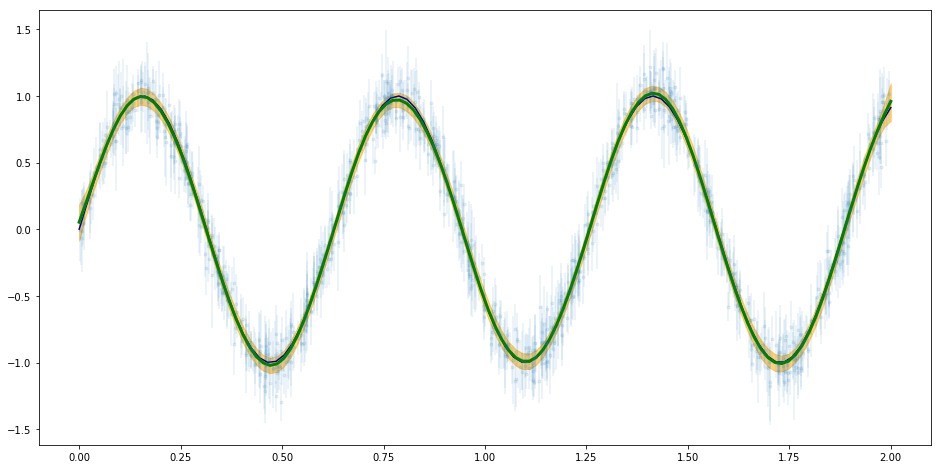

In [305]:
## plot 
plt.figure(figsize=(16, 8))
plt.plot(Xexact.numpy(),Yexact.numpy(),color='navy')
plt.errorbar(Xdata.numpy(), Ydata.numpy(), yerr=sigdata.numpy(),fmt='.',alpha=0.1)
plt.plot(Xtest.numpy(), ftest.mean.numpy(), lw=2, color='orange')
# [plt.plot(Xtest.numpy(), ftest_sample.numpy(), lw=2, color='m')\
#  for ftest_sample in ftest_samples]
plt.plot(Xtest.numpy(), fstar_test.detach().numpy().reshape(-1), lw=3, color='green')

plt.fill_between(Xtest,
                 ftest.mean.numpy() - 1.96 * np.sqrt(ftest.variance.detach().numpy()),
                 ftest.mean.numpy() + 1.96 * np.sqrt(ftest.variance.detach().numpy()),
                 color='orange', alpha=0.5)
